In [53]:
import re
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import networkx as nx
from scipy.linalg import fractional_matrix_power
from sklearn.cluster import KMeans

In [2]:
def read_file_ribo(file_name, one_type_reads, all_reada, one_type_modifs, all_modifs):
    f = open(file_name, 'r', encoding='utf8')
    line = f.readline().strip()
    while line != '':
        parts = re.split('\s+', line)
        one_type_reads.append(parts[0])
        all_reads.append(parts[0])
        modif = parts[1:]
        one_type_modifs.append(list(int(i) for i in modif))
        all_modifs.append(list(int(i) for i in modif))
        line = f.readline().strip()
    f.close()

In [3]:
def read_file_simulated(file_name, type1_reads, type2_reads, all_reads, type1_modifs, type2_modifs, all_modifs):
    f = open(file_name, 'r')
    line = f.readline().strip()
    while line != '':
        parts = re.split('\t', line)
        modif = parts[1].split(" ")
        if parts[2] == '0':
            type1_reads.append(parts[0])
            type1_modifs.append(list(int(i) for i in modif))
        else:
            type2_reads.append(parts[0])
            type2_modifs.append(list(int(i) for i in modif))
        
        all_reads.append(parts[0])
        all_modifs.append(list(int(i) for i in modif))
        line = f.readline().strip()
    f.close()

In [7]:
def read_significant_positions(file_name):
    positions = []
    f = open(file_name, 'r')
    line = f.readline()
    positions = line.strip().split("\t")
    return positions

In [63]:
def get_reads_for_observing(file_name, reads_for_observing, reads_for_observing_with_name):
    f = open(file_name, "r")
    line = f.readline()
    while line != "":
        parts = line.strip().split("\t")
        modifs = parts[1].split(" ")
        reads_for_observing.append(modifs)
        reads_for_observing_with_name.append((modifs, parts[0]))
        line = f.readline()
    f.close()
        

In [20]:
def get_wlist_and_position_data(positions, reads_for_observing, w_list, positions_data):
    for p in range(len(positions)):
        p_data = []
        sum_p = 0
        for read in reads_for_observing:
            sum_p += int(read[p])
            p_data.append(read[p])
        avg_p = sum_p / len(reads_for_observing)
    
        positions_data.append(p_data)
        w_list.append(avg_p)

In [39]:
def calculate_adj_matrix(adj_matrix, positions, positions_data, w_list):
    for i in range(len(positions)):
        for j in range(len(positions)):
            if i == j:
                continue
            scalar_dot = 0
            for k in range(len(positions_data[i])):
                if int(positions_data[i][k]) == 1 and int(positions_data[j][k]) == 1:
                    scalar_dot += 1     
            adj = scalar_dot / math.sqrt(w_list[i] * w_list[j])

            adj_matrix[i][j] = adj
            adj_matrix[j][i] = adj
    print(adj_matrix)


In [43]:
def plot_graph(adj_matrix):
    G = nx.from_numpy_matrix(np.matrix(adj_matrix), create_using=nx.DiGraph)
    layout = nx.spring_layout(G)
    nx.draw(G, layout)
    nx.draw(G,edge_color = [ i[2]['weight'] for i in G.edges(data=True) ] )
    #nx.draw_networkx_edge_labels(G, pos=layout)
    plt.figure(figsize=(50,40))
    plt.show()



In [51]:
def calculate_eigenvalues_and_eigenvectors(adj_matrix):
    D = np.diag(adj_matrix.sum(axis=1))
    L = D-adj_matrix
       
    D1_2 = fractional_matrix_power(D, -0.5)
    Lnorm = np.matmul(D1_2, L, D1_2)
    vals, vecs = np.linalg.eig(Lnorm)
    
    return vals, vecs

In [48]:
def plot_eigenvalues(vals):
    fig = plt.figure(figsize=[18, 6])
    ax1 = plt.subplot(131)
    plt.plot(vals)
    ax1.title.set_text('eigenvalues')

In [58]:
def kmeans(expected_number_of_clusters, vecs):
    kmeans = KMeans(n_clusters=expected_number_of_clusters)
    kmeans.fit(vecs[:, :])
    clusters = kmeans.labels_

    print("Clusters:", clusters)
    return clusters

In [125]:
def get_clusters(cluster_1, cluster_2, same_cluster_1, same_cluster_2,
                 labels, reads_for_observing_with_name):
    c1_1 = cluster_1.count(1)
    c2_1 = cluster_2.count(1)

    if c1_1 > c2_1:
        cluster_temp = cluster_2
        c_temp = c2_1
    else:
        cluster_temp = cluster_1
        c_temp = c1_1


    if c1_1 > 1 and c2_1 > 1:
        for read, name in reads_for_observing_with_name:
            for_cluster_1 = 0
            for i,l in enumerate(cluster_temp):
                if l == 1:
                    if int(read[i]) == 0:
                        for_cluster_1 += 1
     
            limit = math.ceil(c_temp/2)
            if for_cluster_1 > limit:
                same_cluster_1.append(name)
                labels.append(1)
            else:
                same_cluster_2.append(name)
                labels.append(0)
    else:  
        for read, name in reads_for_observing_with_name:
            for_cluster_1 = False
            for i,l in enumerate(cluster_temp):
                if l == 1:
                    if int(read[i]) == 1:
                        same_cluster_1.append(name)
                        labels.append(1)
                        for_cluster_1 = True
                        break
            if not for_cluster_1:
                same_cluster_2.append(name)
                labels.append(0)

In [79]:
def save_reads_with_clusters(file_name, same_cluster_1, same_cluster_2):
    f = open(file_name, "w")
    for read in same_cluster_1:
        line = read + " : " + str(0) + "\n"
        f.write(line)
    for read in same_cluster_2:
        line = read + " : " + str(1) + "\n"
        f.write(line)
    f.close()

# FILE READING REAL DATA

In [70]:
ligand_reads = []
noligand_reads = []
all_reads = []
ligand_modifs = []
noligand_modifs = []
all_modifs = []

read_file_ribo('TPP_TenA_ligand.tsv', ligand_reads, all_reads, ligand_modifs, all_modifs)
read_file_ribo('TPP_TenA_noligand.tsv', noligand_reads, all_reads, noligand_modifs, all_modifs)


# FILE READING SIMULATED DATA

In [68]:
ligand_reads = []
noligand_reads = []
all_reads = []
ligand_modifs = []
noligand_modifs = []
all_modifs = []

read_file_simulated("TPP_simulated_reads_for_clustering_beginning_end_middle4010.txt", 
                    ligand_reads, noligand_reads, all_reads, ligand_modifs, noligand_modifs, 
                    all_modifs)

# GSC FOR REAL DATA

In [71]:
positions = read_significant_positions("TPP_significant_positions.txt")

In [112]:
reads_for_observing = []
reads_for_observing_with_name = []
get_reads_for_observing("TPP_reads_with_significant_positions.txt", reads_for_observing, reads_for_observing_with_name)

In [113]:
w_list = []
positions_data = []
get_wlist_and_position_data(positions, reads_for_observing, w_list, positions_data)

[[   0 3488 1812 3022 3769 2314 1671 2868 1849  703]
 [3488    0 3220 5518 6777 4222 3228 5859 3720 1268]
 [1812 3220    0 2678 3395 2414 1791 2825 1896  650]
 [3022 5518 2678    0 5723 3704 2836 5276 3069 1383]
 [3769 6777 3395 5723    0 4627 3656 6510 4059 1506]
 [2314 4222 2414 3704 4627    0 2357 4173 2529 1152]
 [1671 3228 1791 2836 3656 2357    0 3280 2230  962]
 [2868 5859 2825 5276 6510 4173 3280    0 3426 1245]
 [1849 3720 1896 3069 4059 2529 2230 3426    0  959]
 [ 703 1268  650 1383 1506 1152  962 1245  959    0]]


/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes
/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3

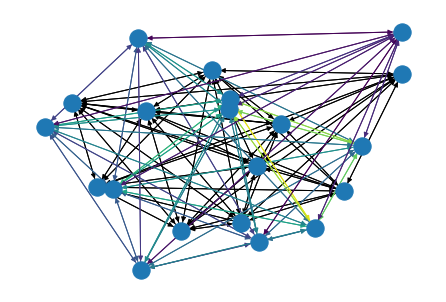

<Figure size 3600x2880 with 0 Axes>

In [115]:
adj_matrix = np.array([[0] * len(positions)] * len(positions))
calculate_adj_matrix(adj_matrix, positions, positions_data, w_list)
plot_graph(adj_matrix)

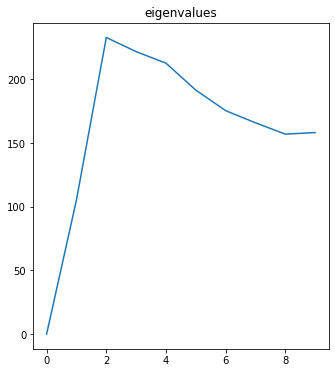

In [116]:
vals, vecs = calculate_eigenvalues_and_eigenvectors(adj_matrix)
plot_eigenvalues(vals)

In [126]:
clusters = kmeans(2, vecs)
cluster_1 = list(clusters)
cluster_2 = [1 if i == 0 else 0 for i in cluster_1]

same_cluster_1 = []
same_cluster_2 = []
labels = []

get_clusters(cluster_1, cluster_2, same_cluster_1, same_cluster_2,
                 labels, reads_for_observing_with_name)

Clusters: [1 1 1 0 1 0 0 1 0 1]


In [127]:
save_reads_with_clusters("TPP_clusters_GSC.txt", same_cluster_1, same_cluster_2)

# GSC FOR SIMULATED DATA

In [134]:
positions = read_significant_positions("TPP_simulated_significant_positions.txt")

In [133]:
reads_for_observing = []
reads_for_observing_with_name = []
get_reads_for_observing("TPP_simulated_reads_with_significant_positions.txt", reads_for_observing, reads_for_observing_with_name)

In [135]:
w_list = []
positions_data = []
get_wlist_and_position_data(positions, reads_for_observing, w_list, positions_data)

[[   0  612  620  612  621  656  133  653   39   83]
 [ 612    0 5636 5644 5651 5641  611  284  714  662]
 [ 620 5636    0 5633 5640 5628  609  315  695  660]
 [ 612 5644 5633    0 5646 5634  600  294  687  652]
 [ 621 5651 5640 5646    0 5639  601  281  697  644]
 [ 656 5641 5628 5634 5639    0  629  305  695  643]
 [ 133  611  609  600  601  629    0  567   85   45]
 [ 653  284  315  294  281  305  567    0  651  622]
 [  39  714  695  687  697  695   85  651    0   39]
 [  83  662  660  652  644  643   45  622   39    0]]


/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes
/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3

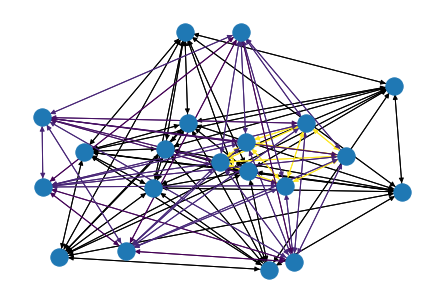

<Figure size 3600x2880 with 0 Axes>

In [136]:
adj_matrix = np.array([[0] * len(positions)] * len(positions))
calculate_adj_matrix(adj_matrix, positions, positions_data, w_list)
plot_graph(adj_matrix)

In [ ]:
vals, vecs = calculate_eigenvalues_and_eigenvectors(adj_matrix)
plot_eigenvalues(vals)